# User Churn Prediction

This is one of the course work. And I am trying to identify customers who are likely to stop using service in the future. 


## Executive Summary:

1. In this projectm, I used 11 most popular models to do the prediction and then used grid search to do the hyperparameter tuning to find the best parameter for each of the model. 
2. From the feature importance analysis we can understand that customer with higher charge are more likly to churn. And customer who calls more with sutomer service will be more likely to churn as well.
3. In really life we need to find a precision recall balance by minimize the cost of the model. We can try to find how each error will cost in really life. And find a threshhold. Which determines the final parameters.

## Steps:

* [Part 0: Setup](#Part-0:-Setup)
* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
* [Part 4: Prediction and Precision Recall Trade Off](#Part-4:-Prediction-and-Precision-Recall-Trade-Off)

# Part 0: Setup

* Read file and check out the data.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns



churn_df = pd.read_csv('churn.all')

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [2]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [3]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


### Part 1.2: Data cleaning

Remove Extra Whitespace

In [4]:
# check categorical feature
churn_df['voice_mail_plan'][0]

' yes'

In [5]:
# remove the heading and trailing whitespaces
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].apply(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].apply(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].apply(lambda x: x.strip())

In [6]:
# check the categorical feature after manipulation
churn_df['voice_mail_plan'][0]

'yes'

### Part 1.3:  Understand the features

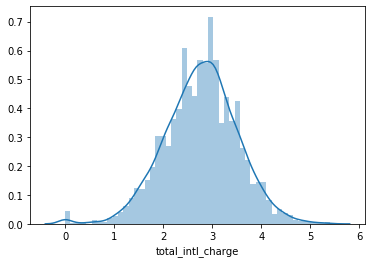

In [7]:
# check the feature distribution
sns.distplot(churn_df['total_intl_charge'])

In [8]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous, df):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), 
                      color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by churned or not
    if continuous:
        sns.boxplot(x=col_name, y='churned', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['ch'].value_counts(normalize=True)[:,1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, 
                    color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction churned')
        ax2.set_title('churned Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'churned', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='churned', data=df, 
                      order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

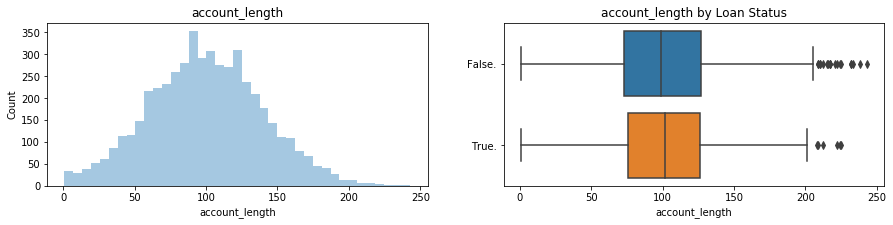

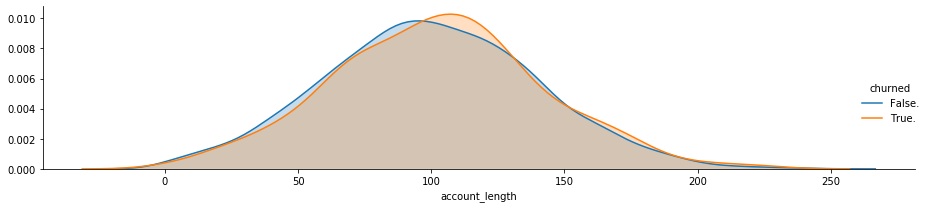

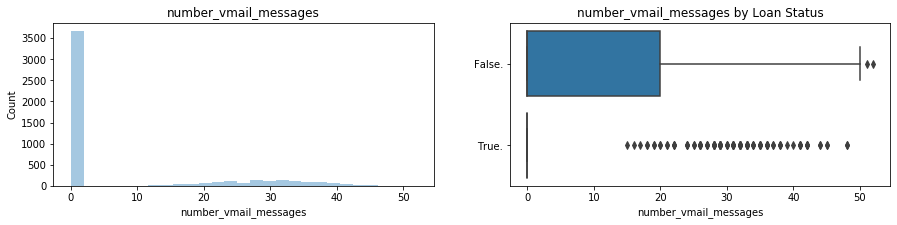

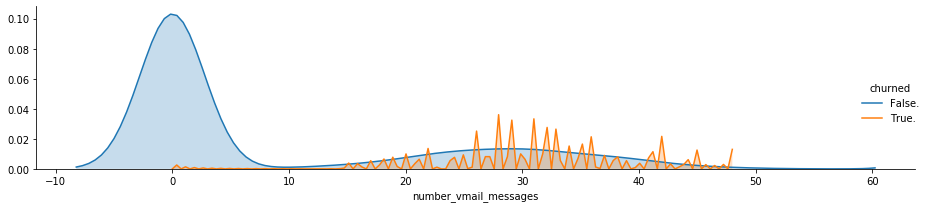

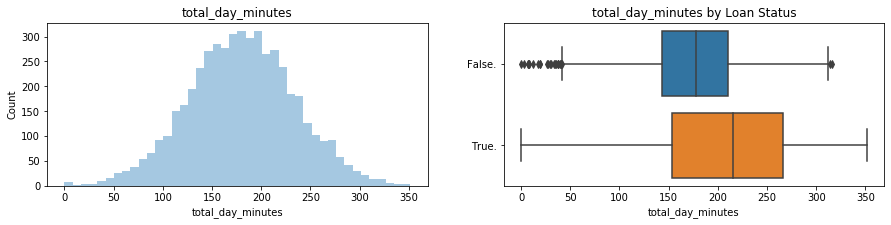

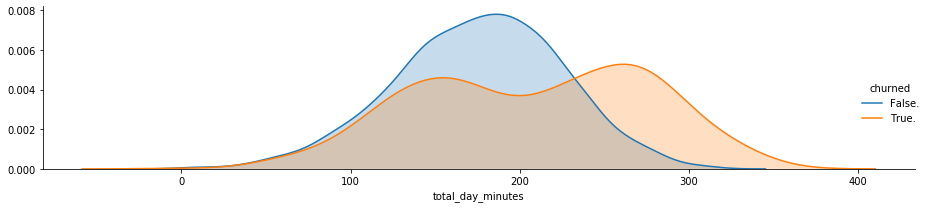

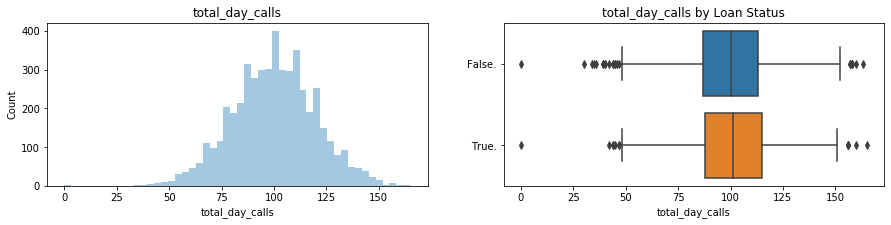

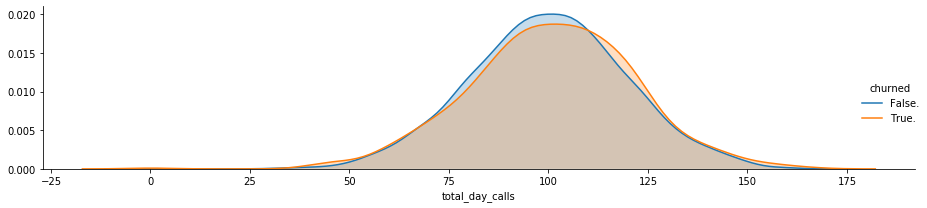

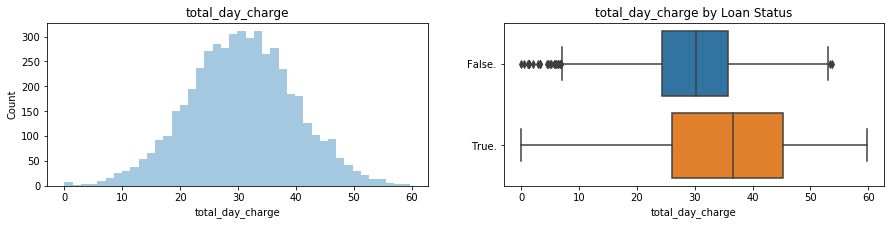

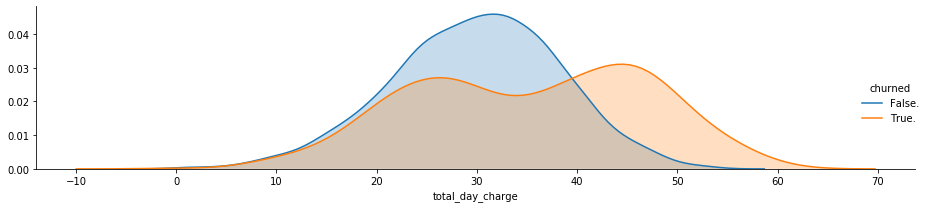

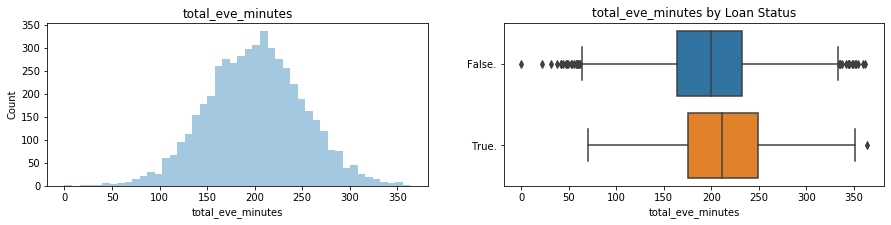

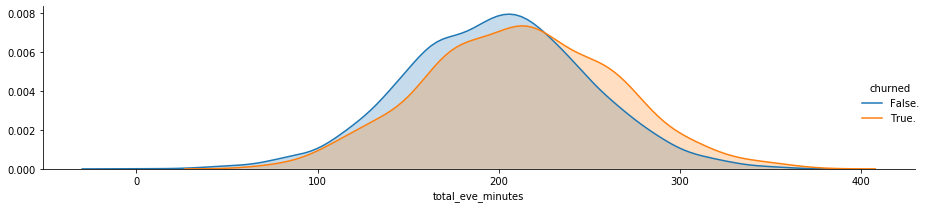

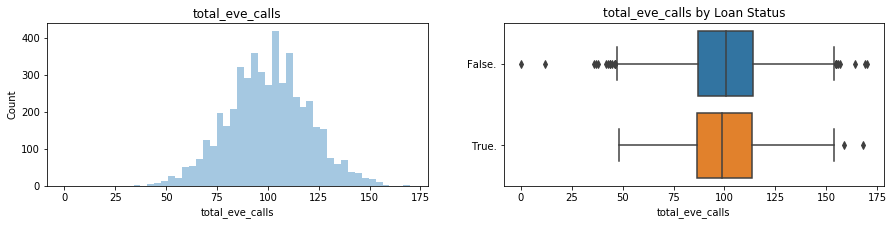

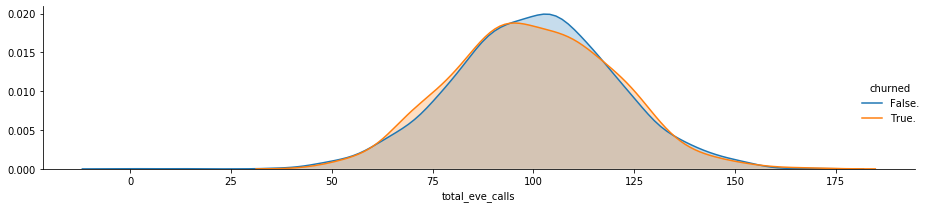

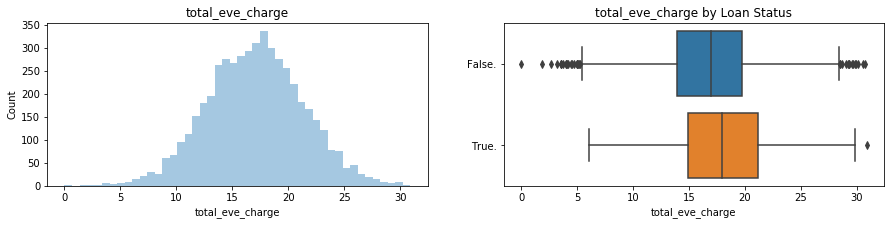

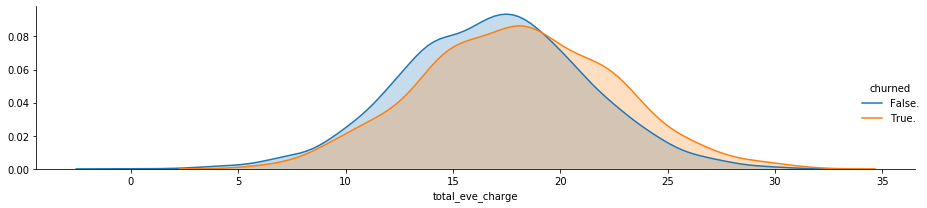

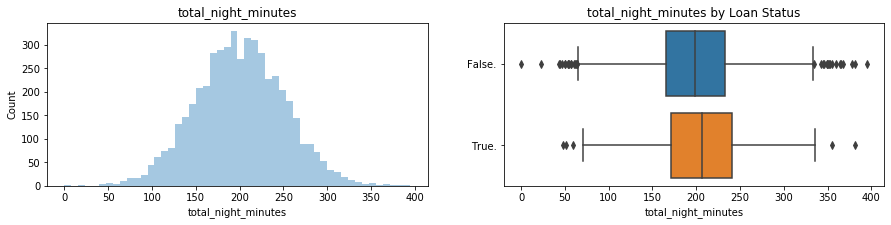

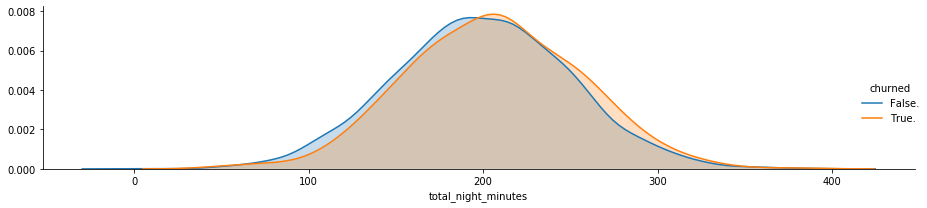

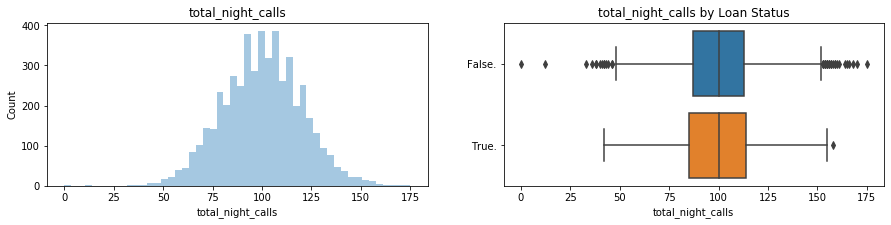

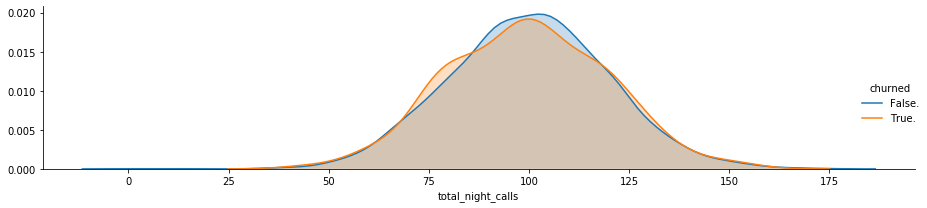

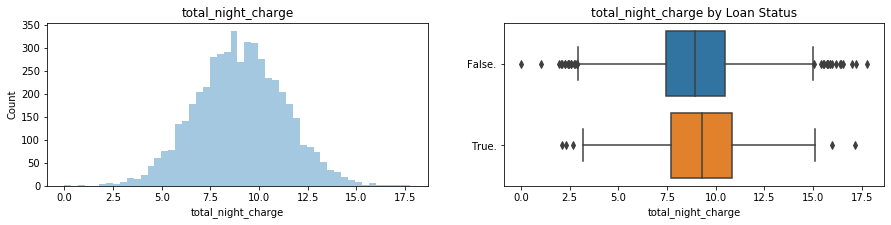

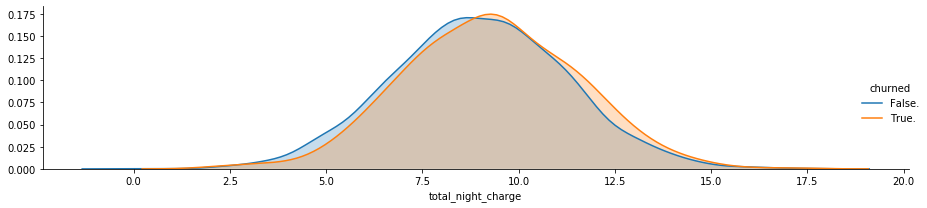

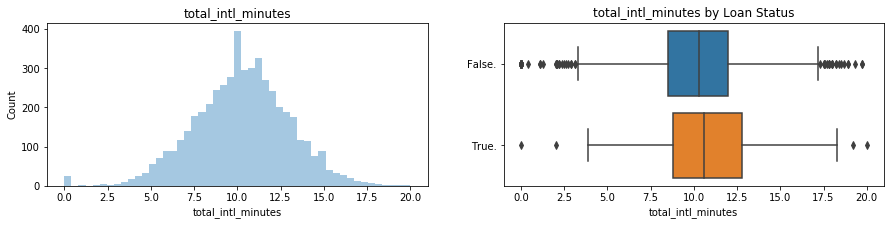

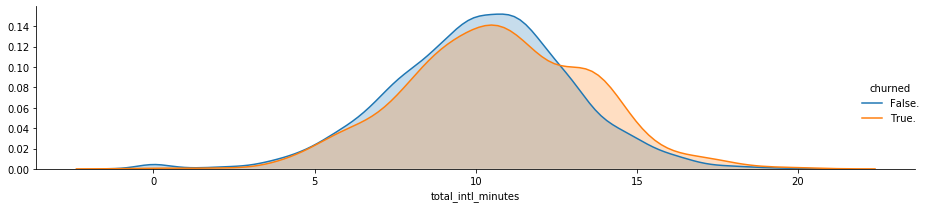

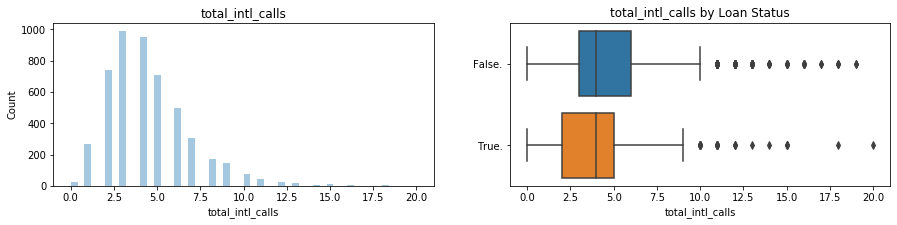

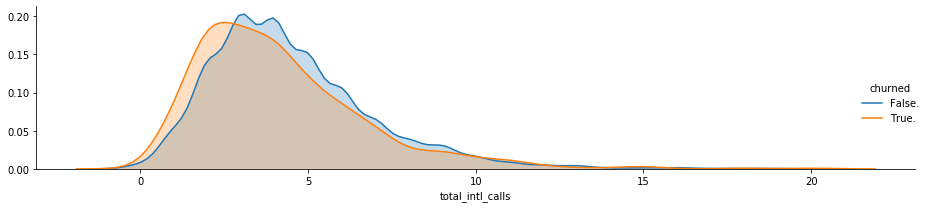

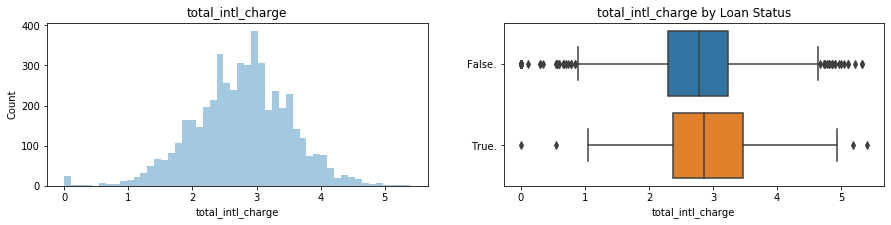

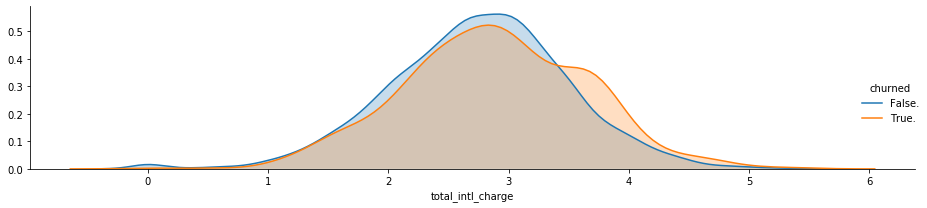

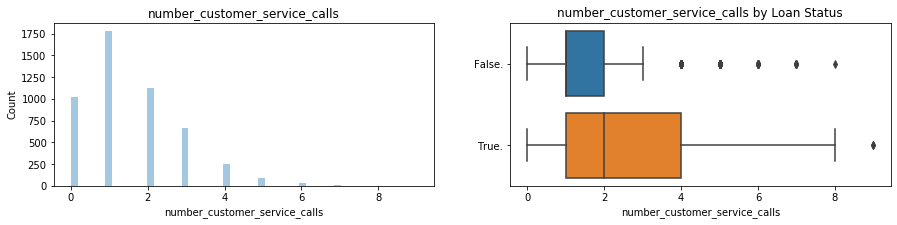

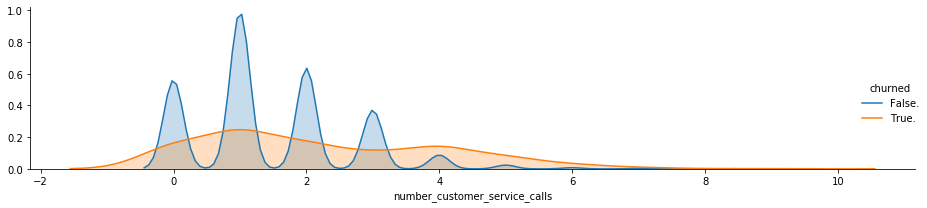

In [9]:
ks_list = ['account_length','number_vmail_messages','total_day_minutes',
           'total_day_calls','total_day_charge', 'total_eve_minutes', 
           'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 
           'total_night_calls', 'total_night_charge', 'total_intl_minutes', 
           'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']
for plot_element in ks_list:
    plot_var(plot_element, plot_element, continuous=True, df=churn_df)

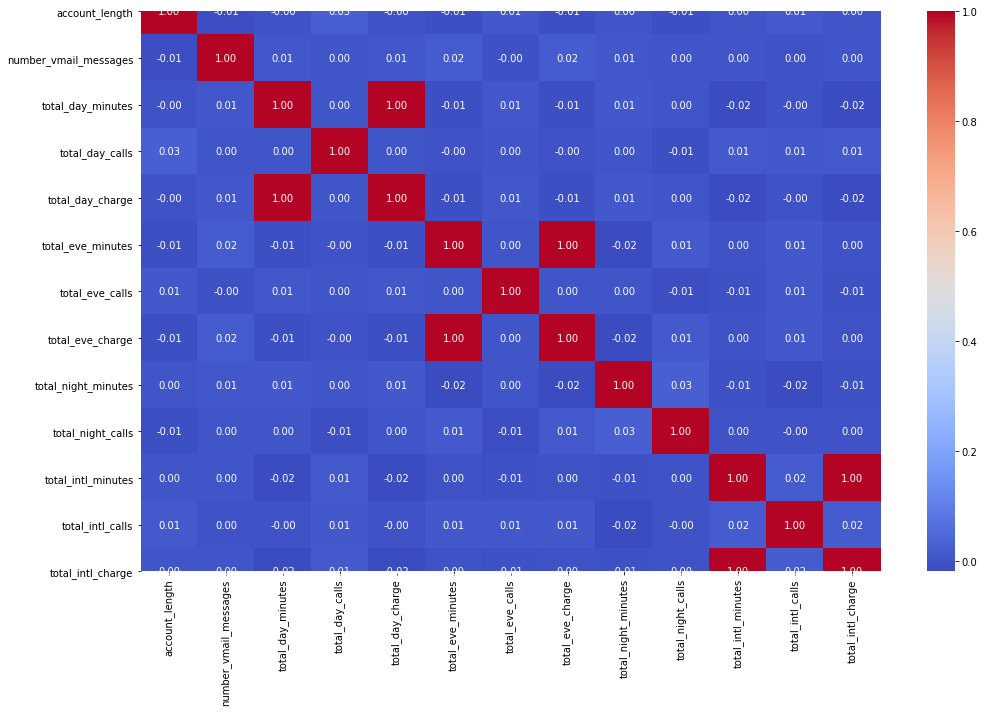

In [10]:
# correlations between all the features
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

# show heapmap of correlations
# , annot=True, fmt = ".2f", cmap = "coolwarm"
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(corr, annot=True, fmt = ".2f", cmap = "coolwarm")
#sns.set_context('talk')
plt.tight_layout()

In [11]:
# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.000391,-0.000156,0.000368


# Part 2: Feature Preprocessing

In [12]:
# calculate two features correlation
from scipy.stats import pearsonr
print (pearsonr(churn_df['total_day_minutes'], churn_df['number_vmail_messages'])[0])

0.005381375960654535


In [13]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [14]:
# Get ground truth data
y = np.where(churn_df['churned'] == 'True.',1,0)

# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

X = churn_feat_space

In [15]:
# check the propotion of y = 1
print(y.sum() / y.shape * 100)

[14.14]


#### Add catogorical features, e.g. state, into feature matrix

Read more for handling [categorical feature](https://github.com/scikit-learn-contrib/categorical-encoding)

In [16]:
to_drop_hw1 = ['area_code','phone_number','churned']
churn_feat_space_hw1 = churn_df.drop(to_drop_hw1, axis=1)

# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space_hw1[yes_no_cols] = churn_feat_space_hw1[yes_no_cols] == 'yes'

# sklearn.preprocessing.OneHotEncoder
churn_feat_space_hw1 = pd.get_dummies(churn_feat_space_hw1, columns=['state'])

churn_feat_space_hw1.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,137,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,75,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
from sklearn.model_selection import train_test_split

# Reserve 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 17 features
test data has 1000 observation with 17 features


- Scale the data, using standardization

standardization (x-mean)/std

normalization (x-x_min)/(x_max-x_min)

1. speed up gradient descent
2. same scale

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X.columns)

X_train.sample(5)

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
83,-0.832043,-0.329151,-0.608935,-0.580578,-1.201798,-1.502058,-1.201315,1.020176,2.136503,1.020829,0.177039,-0.458103,0.176766,-1.002432,0.632069,-0.996412,-1.193816
11,0.572027,-0.329151,-0.608935,-0.580578,0.850287,0.104582,0.850008,0.495600,-2.200208,0.494850,-0.261487,1.401142,-0.262199,-1.294296,-0.998288,-1.293703,-0.428304
1231,0.446663,-0.329151,-0.608935,-0.580578,-0.817847,1.008317,-0.817583,0.066402,0.142613,0.067054,0.558281,-0.508353,0.558666,0.383919,-0.183109,0.381934,-0.428304
1957,-0.857115,-0.329151,-0.608935,-0.580578,-0.484221,1.661015,-0.484284,-0.038911,1.039864,-0.038142,-0.948908,-0.005854,-0.946985,-0.272774,-0.590698,-0.266700,1.868232
2760,0.923044,-0.329151,-0.608935,-0.580578,-0.724656,-0.447700,-0.724391,-1.066205,-0.006929,-1.066724,1.081748,-1.262101,1.081034,-0.820018,1.039658,-0.820741,0.337208




Now, we have prepared our data, exciting to build the model.

# Part 3: Model Training and Result Evaluation

### 3.0: Load Packages

Below, I will perform modeling for the most popular 11 models.

1. Logistic Regression
2. Linear Discriminant Analysis
3. SVC
4. KNN
5. Random Forest (RFC)
6. Decision Tree
7. Extra Trees (ExtC)
8. AdaBoost (Ada)
9. Gradient Boosting (GBC)
10. Multiple layer perceptron (neural network)
11. XGBoost

In [20]:
# Splite data into training and testing
from sklearn import model_selection
from collections import Counter


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import  XGBClassifier


### 3.1: Stratified K-fold Cross Validation

This step is used to find the best models in this context and then we could move on to grid search and fine hyhperparameter tuning.

Since the data is unbalanced, we use the Stratified K-fold Cross Validation

In [21]:
kfold = StratifiedKFold(n_splits=5)

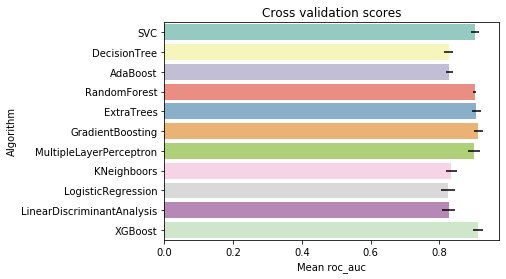

In [22]:
# Test differents algorithms 
random_state = 21
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.01))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state=random_state))


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBoost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean roc_auc")
g = g.set_title("Cross validation scores")

In [23]:
cv_res.sort_values("CrossValMeans", ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
10,0.913676,0.014396,XGBoost
5,0.913589,0.012959,GradientBoosting
4,0.907802,0.013154,ExtraTrees
0,0.903927,0.012362,SVC
3,0.902947,0.004474,RandomForest
6,0.900746,0.017371,MultipleLayerPerceptron
7,0.835096,0.016359,KNeighboors
2,0.828869,0.010655,AdaBoost
9,0.827509,0.019222,LinearDiscriminantAnalysis
1,0.827084,0.013390,DecisionTree


From the table we can clearly see what model performs will on the cross validation process of training data. And then I select some models from the list.

1. SVC -> Support Vector Classifier
2. GradientBoosting
3. XGBoost
4. LogisticRegression
5. KNeighboors
6. RandomForest

### 3.2: Hyperparameter tunning for best models

**Gradient Boosting**

In [24]:
# find the optimal model with grid search.

gb = GradientBoostingClassifier(random_state=random_state)
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100, 280,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [14, 15],
              'min_samples_leaf': [100, 120],
              'max_features': [0.4, 0.3] 
              }

# since I have four core of my computer, so I will use all my cores. then n_jobs = -1
# kfold is the stratified 5 folds cross validation defined ablove.
# Since this is a classification problem, I will use roc (recriver operator curve) and Auc 
grid_gb = GridSearchCV(gb, param_grid=gb_param_grid, cv=kfold, 
                       scoring='roc_auc', verbose=1,n_jobs=-1)
grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split...
                                                  subsample=1.0, tol=0.0001,
                                                  validation_fraction=0.1,
                                                  verb

In [25]:
gb_best = grid_gb.best_estimator_

def printBest(grid):
    print('Best Score:', grid.best_score_)
    print('Best parameters set: \n', grid.best_params_)
    
printBest(grid=grid_gb)

Best Score: 0.9131484714258153
Best parameters set: 
 {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 120, 'n_estimators': 300}


In [26]:
# Lets store the predicted values for gradient boosting.

y_pred_gb = gb_best.predict(X_test)
y_prob_gb = gb_best.predict_proba(X_test)[:,1]

**XGBoost**

In [27]:
xgb = GradientBoostingClassifier()

xgb_param_grid = {
    'learning_rate': [0.025, 0.05, 0.1],
    'max_depth': [3,4,5],
    'subsample': [0.25, 0.5, 1.0]
}

grid_xgb = GridSearchCV(xgb, cv=kfold, param_grid=xgb_param_grid, 
                        scoring='roc_auc', n_jobs=-1, verbose=1)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   19.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split...
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort='auto',

In [28]:
xgb_best = grid_xgb.best_estimator_

printBest(grid_xgb)

Best Score: 0.9157727488535239
Best parameters set: 
 {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5}


In [29]:
y_pred_xgb = xgb_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)[:,1]

**SVM**

More SVM kernel info please visit here: https://data-flair.training/blogs/svm-kernel-functions/

Lets us the general purpose kernel: Gaussian radial basis function (RBF), used when there is no prior knowledge about the data.

In [30]:
svm = SVC(probability=True)
svm_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

grid_svm = GridSearchCV(svm, param_grid = svm_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_svm.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [31]:
svm_best = grid_svm.best_estimator_
printBest(grid_svm)

Best Score: 0.9093897193397745
Best parameters set: 
 {'C': 200, 'gamma': 0.01, 'kernel': 'rbf'}


In [32]:
y_pred_svm = svm_best.predict(X_test)
y_prob_svm = svm_best.predict_proba(X_test)[:,1]

**Random Forest**

In [33]:
# Build ranfom forest and set the parameter grid. 
rf = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=42)

rf_param_grid = {
    "max_features": range(2,7),
    "min_samples_split": range(4,10),
    "min_samples_leaf": range(1,6),
}

grid_rf = GridSearchCV(rf, param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_rf.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   44.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False, random_state=42,
                      

In [34]:
# Print the best Score, and parameter.

rf_best = grid_rf.best_estimator_
printBest(grid_rf)

Best Score: 0.9197765976911586
Best parameters set: 
 {'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 9}


In [35]:
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)[:,1]

**KNN**

In [36]:
# Build the KNN classifier and set the parameter grid. 
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors':[4,8,16],
    'weights': ['uniform','distance']
}

grid_knn = GridSearchCV(knn, param_grid = knn_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose = 1)
grid_knn.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [4, 8, 16],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [37]:
knn_best = grid_knn.best_estimator_

printBest(grid_knn)

Best Score: 0.8746259115359168
Best parameters set: 
 {'n_neighbors': 16, 'weights': 'distance'}


In [38]:
y_pred_knn = knn_best.predict(X_test)
y_prob_knn = knn_best.predict_proba(X_test)[:,1]

**Logistic Regression**

In [39]:
# Lets build the Logistic Regression classifier and set the parameter grid.

lr = LogisticRegression()
C_grid = 0.001*10**(np.arange(0,1.01,0.01)*3)
lr_param_grid  = {
    'penalty': ['l1', 'l2'], 
    'C': C_grid
}

grid_lr = GridSearchCV(lr, lr_param_grid, scoring='roc_auc', n_jobs=4)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'C': array([0.001     , 0...
       0.17782794, 0.19054607, 0.20417379, 0.21877616, 0.23442288,
       0.25118864, 0.26915348, 0.28840315, 0.30902954, 0.33113112,
       0.35481339, 0.3801894 , 0.40738028, 0.43651583, 0.46773514,
       0.50118723, 0.5370318 , 0.57543994, 0.616595  , 0.66069345,
       0.70794578, 

In [40]:
lr_best = grid_lr.best_estimator_
printBest(grid_lr)

Best Score: 0.8266112907658729
Best parameters set: 
 {'C': 0.0630957344480193, 'penalty': 'l1'}


In [41]:
y_pred_lr = lr_best.predict(X_test)
y_prob_lr = lr_best.predict_proba(X_test)[:,1]

In [42]:
cv_score_after_grid = [grid_lr.best_score_, grid_gb.best_score_, grid_knn.best_score_, 
                       grid_rf.best_score_, grid_svm.best_score_, grid_xgb.best_score_]

cv_res_after_grid_search = pd.DataFrame({"Score":cv_score_after_grid,
                                         "Algorithm":["LogisticRegression","GradientBoosting","KNeighboors",
                                                      "RandomForest","SVM","XGBoost"]})
cv_res_after_grid_search.sort_values("Score", ascending=False)


,Score,Algorithm
3,0.919777,RandomForest
5,0.915773,XGBoost
1,0.913148,GradientBoosting
4,0.909390,SVM
2,0.874626,KNeighboors
0,0.826611,LogisticRegression


### 3.3: Learning curve. 
Now we have optimized all the parameters. Seems like the the random forest becomes the best model here. 

<module 'matplotlib.pyplot' from '/Users/yinruideng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

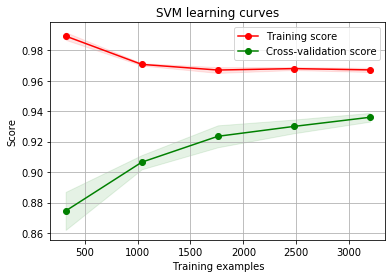

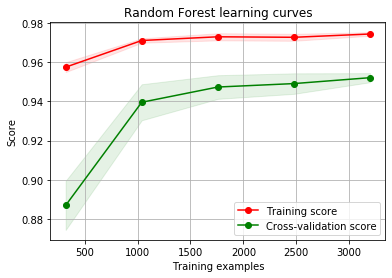

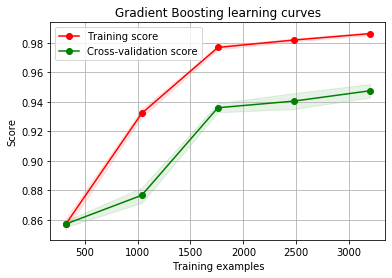

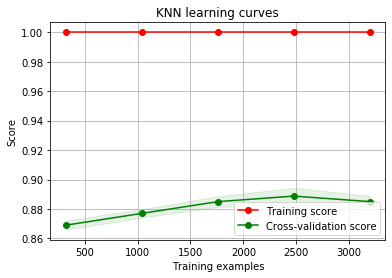

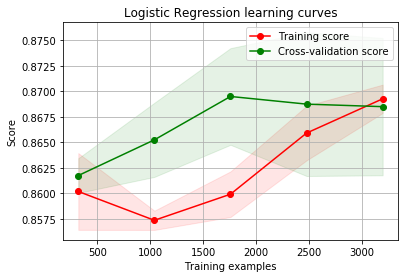

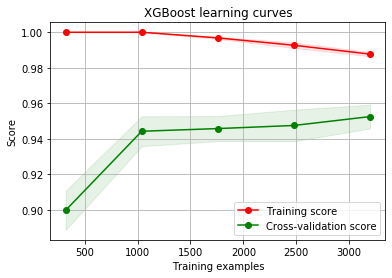

In [43]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(grid_svm.best_estimator_,"SVM learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(grid_rf.best_estimator_,"Random Forest learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(grid_gb.best_estimator_,"Gradient Boosting learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(grid_knn.best_estimator_,"KNN learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(grid_lr.best_estimator_,"Logistic Regression learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(grid_xgb.best_estimator_,"XGBoost learning curves",X_train,y_train,cv=kfold)

From the above we can clearly see the learning path for each model. Next Lets do confusion matrix.

### 3.4: Confusion Matrix 

class of interest as positive

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

- Positive: Churn,   Negative: Not churn.
- The biggest proportion of data is negative, and prediction has mostly true negative.
- In this case, out goal is to retain as many customers. We would rather spend more money on them than letting them go, so we really care about the false positive rate. We may lose a customer if someone will actually churn but we predict not. 
- It is okay to spend a little more money false negative.
- So, we care more about Precision here. 

In [44]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

def cal_evaluation(classifier, cm, auc):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2 * precision * recall / (precision + recall)
    print(classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)
    print("F1 score is " + str(f1))
    print("ROC AUC is " + str(auc))

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        cal_evaluation(classifier, cm, auc)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for {}'.format(classifier))
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

[0 1]
Gradient Boosting
Accuracy is: 0.952
precision is: 0.874
recall is: 0.776
F1 score is 0.8222222222222223
ROC AUC is 0.9421628546482689


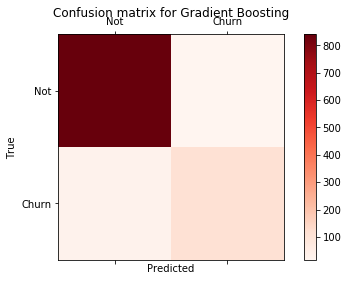

Logisitic Regression
Accuracy is: 0.850
precision is: 0.436
recall is: 0.168
F1 score is 0.24242424242424243
ROC AUC is 0.8262682475051203


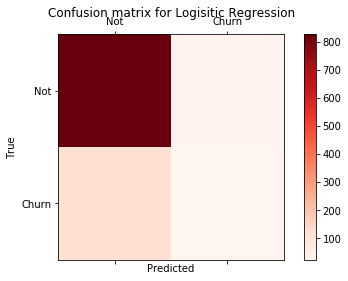

K-Nearest-Neighbors
Accuracy is: 0.884
precision is: 0.814
recall is: 0.245
F1 score is 0.37634408602150543
ROC AUC is 0.9014451126469796


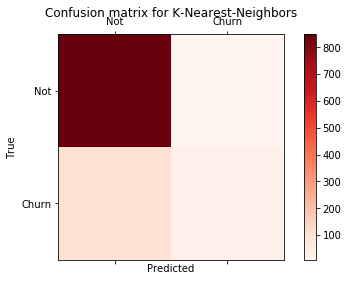

Random Forest
Accuracy is: 0.958
precision is: 0.898
recall is: 0.797
F1 score is 0.8444444444444443
ROC AUC is 0.9310899135869966


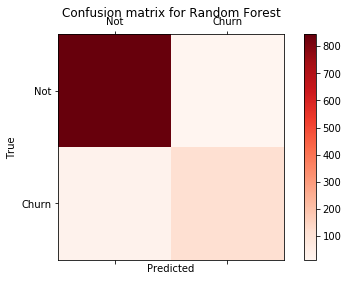

Support Vector Machine
Accuracy is: 0.933
precision is: 0.833
recall is: 0.664
F1 score is 0.7392996108949418
ROC AUC is 0.9399107310425864


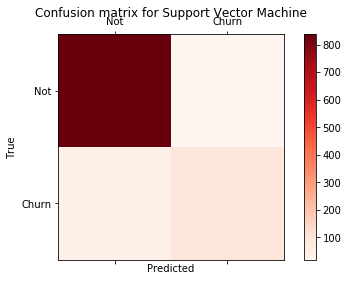

XGBoost Classifier
Accuracy is: 0.958
precision is: 0.885
recall is: 0.811
F1 score is 0.8467153284671532
ROC AUC is 0.9483317149594863


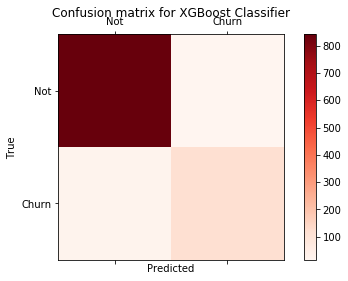

In [45]:
y = np.array(y)
class_names = np.unique(y)
print(class_names)

confusion_matrices = [
    ("Gradient Boosting", confusion_matrix(y_test, y_pred_gb), roc_auc_score(y_test, y_prob_gb)),
    ("Logisitic Regression", confusion_matrix(y_test, y_pred_lr), roc_auc_score(y_test, y_prob_lr)),
    ("K-Nearest-Neighbors", confusion_matrix(y_test, y_pred_knn), roc_auc_score(y_test, y_prob_knn)),
    ("Random Forest", confusion_matrix(y_test, y_pred_rf), roc_auc_score(y_test, y_prob_rf)),
    ("Support Vector Machine", confusion_matrix(y_test, y_pred_svm), roc_auc_score(y_test, y_prob_svm)),
    ("XGBoost Classifier", confusion_matrix(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb))
    
]

draw_confusion_matrices(confusion_matrices)

Here, tree based model all have presicion. However, KNN has the highest precision, it has really low recall. Which means we may caot a lot of money whic is unnessary. Because we do not need to spend too much money to let the loyal customers. We want to alocate more money to these who will churn. 

### 3.5: Feature Importance Analysis

- Here lets do a feature analysis for tree based models. And see if the results are intuitive.

In [46]:
gb_best.feature_importances_

array([0.01403576, 0.11867293, 0.01215429, 0.01041197, 0.17058831,
       0.01012828, 0.21555671, 0.05792609, 0.01118292, 0.04372494,
       0.02003333, 0.01398719, 0.01597017, 0.0397351 , 0.04105727,
       0.04313504, 0.16169969])

In [47]:
gb_best.feature_importances_[::-1]

array([0.16169969, 0.04313504, 0.04105727, 0.0397351 , 0.01597017,
       0.01398719, 0.02003333, 0.04372494, 0.01118292, 0.05792609,
       0.21555671, 0.01012828, 0.17058831, 0.01041197, 0.01215429,
       0.11867293, 0.01403576])

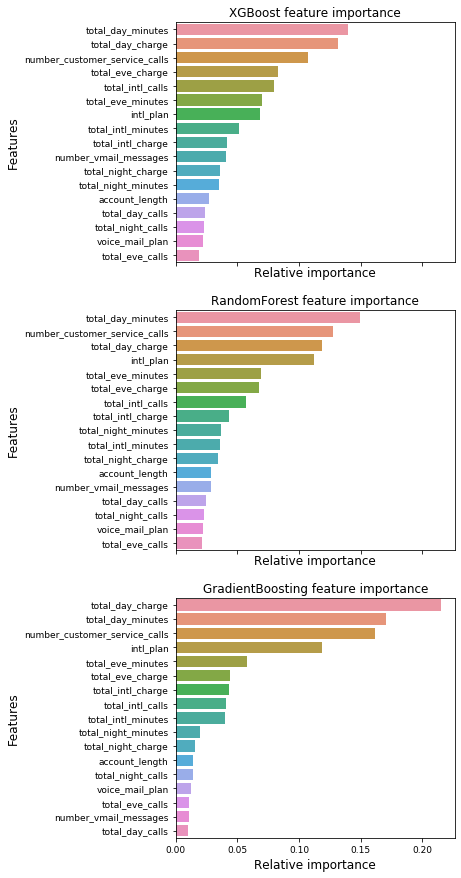

In [48]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, 
                         sharex="all", figsize=(5,15))

names_classifiers = [("XGBoost", xgb_best),("RandomForest",rf_best),
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    
    g = sns.barplot(y=X_train.columns[indices][:40], 
                    x = classifier.feature_importances_[indices][:40], 
                    orient='h',ax=axes[row])
    
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

These are the feature importance to these models. However the details may not be the same. But they all have similar features.

Such as number_customer_service_call, this is really intuitive, because the more often you call the service means the more problem you have. And reasonably have higher chance to churn.

### 3.6: Build Ensemble Model

- Build an ensemble model with all previous model combined. 

In [49]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('lr',lr_best),('knn', knn_best),
('svm', svm_best), ('gb',gb_best),('xgb',xgb_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, y_train)

y_pred_voting = votingC.predict(X_test)
y_prob_voting = votingC.predict_proba(X_test)[:,1]

Ensemble modeling
Accuracy is: 0.954
precision is: 0.937
recall is: 0.727
F1 score is 0.8188976377952756
ROC AUC is 0.9442191414186747


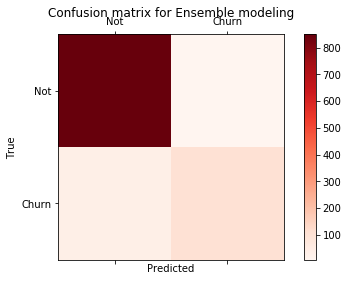

In [50]:
confusion_matrices = [
    ("Ensemble modeling", confusion_matrix(y_test, y_pred_voting), roc_auc_score(y_test, y_prob_voting))   
]
draw_confusion_matrices(confusion_matrices)

So, the ensemble model is not as good as the gradient boosting model when compared with both precision and AUC. I still use gradient boosting model to do the final prediction. 

# Part 4: Prediction and Precision Recall Trade Off

Since the ensemble model is not as good as individual model. I will not use the combined the ensemble model. Instead, I will use XGBoost here.

XGboost
Accuracy is: 0.958
precision is: 0.885
recall is: 0.811
F1 score is 0.8467153284671532
ROC AUC is 0.9483317149594863


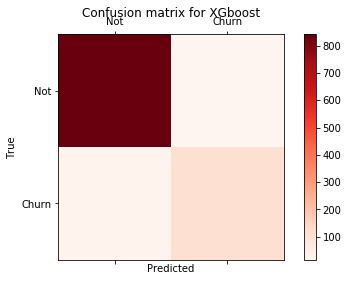

In [51]:
confusion_matrices = [
    ("XGboost", confusion_matrix(y_test, y_pred_xgb), roc_auc_score(y_test, y_prob_xgb))
]

draw_confusion_matrices(confusion_matrices)

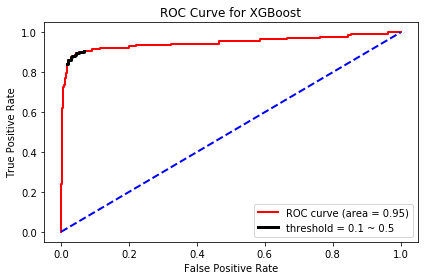

In [52]:
# make the ROC curve
fpr, tpr, thresh = roc_curve(y_test, y_prob_xgb, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob_xgb)

# These are the points at threshold = 0.1~0.5
x1 = fpr[(thresh <= 0.5) & (thresh >= 0.1)] 
x2 = tpr[(thresh <= 0.5) & (thresh >= 0.1)]

fig = plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
plt.plot(x1, x2, color='k', lw=3, label='threshold = 0.1 ~ 0.5')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [53]:
acc_grid = np.zeros(thresh.shape)
prec_grid = np.zeros(thresh.shape)
recall_grid = np.zeros(thresh.shape)
TP_grid = np.zeros(thresh.shape)
FP_grid = np.zeros(thresh.shape)
FN_grid = np.zeros(thresh.shape)

for i in range(thresh.shape[0]):
    cm = confusion_matrix(y_test, y_prob_xgb >= thresh[i])
    acc_grid[i] = accuracy_score(y_test, y_prob_xgb >= thresh[i])
    prec_grid[i] = precision_score(y_test, y_prob_xgb >= thresh[i])
    recall_grid[i] = recall_score(y_test, y_prob_xgb >= thresh[i])
    TP_grid[i] = cm[1][1]
    FP_grid[i] = cm[0][1]
    FN_grid[i] = cm[1][0]

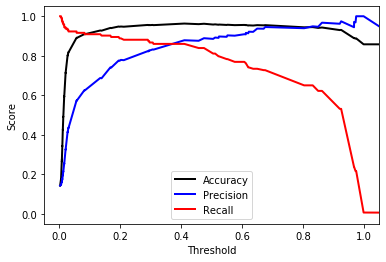

In [54]:
fig = plt.figure()
plt.plot(thresh, acc_grid, color='k', lw=2, label='Accuracy')
plt.plot(thresh, prec_grid, color='b', lw=2, label='Precision')
plt.plot(thresh, recall_grid, color='r', lw=2, label='Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc="lower center")
plt.show()

Here, one way to do to optimize the outcome of the model in real world is by evaluating the possible cost. And we want to minimize the cost. So, I would set different cost options for the confusion matrix.

- Assume customer will chhurn has 50% chance will accept our new lower cost offer. And 100% of loyal customer will stay and accept the lower cost offer. 

1. If the TP / TN accept the offer, the cost will be 0.1.
2. If the customer churned, the cost will be 1.

**Here is just an example of how the loss can be calculated, in really situations, we need to be more careful setting these values.**

In [55]:
P = 0.5 # The chance a customer who was going to drop would take the special offer
loss = TP_grid*P*(-0.1) + TP_grid*(1-P)*(-1) + FN_grid*(-1) + FP_grid*(-0.1)

# Since they are all negative numbers, so the smallest loss is actually the max of the values.
thresh_best = thresh[loss == max(loss)][0]
print('The smallest loss is: ', max(loss))
print('The best thresh hold is : ',thresh_best)


The smallest loss is:  -89.0
The best thresh hold is :  0.29080347855665645


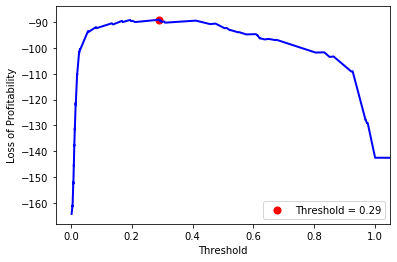

In [56]:
fig = plt.figure()
plt.plot(thresh, loss, color='b', lw=2)
plt.scatter([thresh_best], [max(loss)], color='r', s=50, label='Threshold = {:.2f}'.format(thresh_best))
plt.xlim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Loss of Profitability')
plt.legend(loc="lower right")
plt.show()

XGboost
Accuracy is: 0.955
precision is: 0.822
recall is: 0.874
F1 score is 0.8474576271186441
ROC AUC is 0.9483317149594863


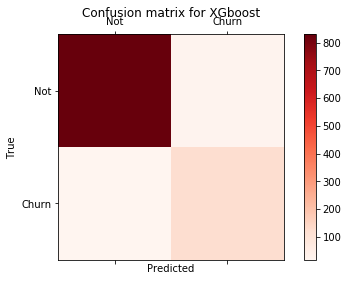

In [57]:
y_pred_xgb_new = y_prob_xgb > thresh_best

confusion_matrices = [
    ("XGboost", confusion_matrix(y_test, y_pred_xgb_new), roc_auc_score(y_test, y_prob_xgb))
]

draw_confusion_matrices(confusion_matrices)